# Exercise 03: CLIP zero-shot prediction
In this exercise, you will perform zero-shot prediction using CLIP.

### Basic Imports

pip install torch torchvision

In [3]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import cv2
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from torchvision.datasets import CIFAR10
from torchvision import datasets
from torchvision import transforms
import torchvision

from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

from clip import clip

### Hyperparameters

In [2]:
# # random seed
# SEED = 1 
# NUM_CLASS = 10

# Training
BATCH_SIZE = 128
# NUM_EPOCHS = 30
# EVAL_INTERVAL=1
# SAVE_DIR = './log'

# # Optimizer
# LEARNING_RATE = 1e-1
# MOMENTUM = 0.9
# STEP=5
# GAMMA=0.5

# CLIP
VISUAL_BACKBONE = ['RN50', 'ViT-B/32', 'ViT-B/16'] # RN50, ViT-B/32, ViT-B/16


### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


In [17]:
# 定义Cats vs. Dogs数据集路径
train_data_path = "/data/lab/STA303-Assignment02/Cats/train"
test_data_path = "/data/lab/STA303-Assignment02/Cats/test"

# 数据集预处理
class CatsDogsDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]

        # 读取图像
        image = Image.open(image_path).convert("RGB")

        # 应用变换
        if self.transform:
            image = self.transform(image)

        return image, label

def read_data(data_path):
    images = [os.path.join(data_path, filename) for filename in os.listdir(data_path)
              if os.path.isfile(os.path.join(data_path, filename))]  # 过滤掉目录
    labels = [0 if "cat" in image_path else 1 for image_path in images]

    return images, labels


# 数据集划分
train_images, train_labels = read_data(train_data_path)
test_images, test_labels = read_data(test_data_path)

# 定义图像变换
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 创建训练和测试数据集
train_set = CatsDogsDataset(train_images, train_labels, transform=image_transform)
test_set = CatsDogsDataset(test_images, test_labels, transform=image_transform)

# 创建数据加载器
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

# Class names for Cats and Dogs
class_names = ['cat', 'dog']

# Dataset name
dataset_name = 'Cats vs. Dogs'

In [4]:
from torchvision.datasets import FashionMNIST

# 定义图像变换
transform_fashionmnist = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # 将单通道图像扩展为3通道
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# 2. 创建FashionMNIST数据集
train_set = FashionMNIST(root='./data', train=True, download=True, transform=transform_fashionmnist)
test_set = FashionMNIST(root='./data', train=False, download=True, transform=transform_fashionmnist)

# 3. 创建FashionMNIST数据加载器，
train_loader = DataLoader(dataset=train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=32, shuffle=False)

# 4. 输出FashionMNIST类别
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
dataset_name = 'FashionMNIST'

In [4]:
transform_cifar10_test = transforms.Compose([
    transforms.Resize(size=224),
    transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
train_set = torchvision.datasets.CIFAR10(root='./CIFAR10', train=True, download=True, transform=transform_cifar10_test)
test_set = torchvision.datasets.CIFAR10(root='/shareddata', train=False,download=True, transform=transform_cifar10_test)

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dataset_name = 'CIFAR10'

100%|██████████| 170498071/170498071 [00:16<00:00, 10074893.71it/s]


Extracting ./CIFAR10/cifar-10-python.tar.gz to ./CIFAR10
Files already downloaded and verified


### Model

### Task 1: Prompt Gereration
---

Please denfine a function named ``prompt_encode`` to encode the text using CLIP text encoder.


In [11]:
#prompt = 'a photo of a' # you can try different prompt
prompt = "asdqwedqwdwda"
#prompt = "a colorful image of a"

In [12]:
from transformers import CLIPProcessor, CLIPModel

def prompt_encode(prompt):
    """
    Args:
        prompt (str): the text prefix before the class

    Returns:
        text_inputs(torch.Tensor)

    """
    ##################### Write your answer here ##################
    text_inputs = torch.cat([clip.tokenize(f"{prompt} {name}")for name in class_names]).to(device)
                                           
    ###############################################################
    
    return text_inputs


In [13]:
text_inputs = prompt_encode(prompt)

### Task 2: Zero-shot inference
---

Please denfine a function named ``model_inference``. The function is essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Encode the image.
2. Encode the text.
3. Calculate the logits.

In [14]:
def model_inference(model, image, text_inputs):

    ##################### Write your answer here ##################
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text_inputs)
  
    
    logits_per_image, logits_per_text = model(image, text_inputs)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    logits = logits_per_image
    
    ###############################################################

    return logits

### Task 3: Zero-shot accuracy calculation
---

In [9]:
testing_loss = []
testing_acc = []

for VISUAL_BACKBONE in ['RN50', 'ViT-B/32', 'ViT-B/16']:
    
    model, preprocess = clip.load(name=VISUAL_BACKBONE, device=device, download_root='/shareddata/clip/')
    model.to(device)
    
    with torch.no_grad():
        model.eval()
 
    ##################### Write your answer here ##################
        correct_predictions=0
    
        for image, class_id in test_loader:
            image = image.to(device)
            class_id = class_id.to(device).long()
        
            logits = model_inference(model,image,text_inputs)
            #print(image)
            #print(text_inputs)
            
            predictions = logits.argmax(dim=-1)
            correct_predictions += (predictions == class_id).sum().item()

    
        val_acc = correct_predictions / len(test_set)

     ###############################################################
    print(f"the zero-shot performance on {dataset_name} is {val_acc*100:.2f}%, visual encoder is {VISUAL_BACKBONE}.")


the zero-shot performance on CIFAR10 is 54.95%, visual encoder is RN50.
the zero-shot performance on CIFAR10 is 85.15%, visual encoder is ViT-B/32.
the zero-shot performance on CIFAR10 is 86.83%, visual encoder is ViT-B/16.


In [ ]:
# 定义基准模型
class BaselineModel(nn.Module):
    def __init__(self, num_classes=10):
        super(BaselineModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3 * 224 * 224, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        return x

# 实例化模型和定义损失函数、优化器
baseline_model = BaselineModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(baseline_model.parameters(), lr=0.001, momentum=0.9)

# 训练模型
for epoch in range(5):  # 假设进行5个Epoch的训练
    baseline_model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = baseline_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# 在测试集上计算准确率
baseline_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = baseline_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Baseline Model Accuracy on CIFAR10 Dataset: {accuracy * 100:.2f}%')

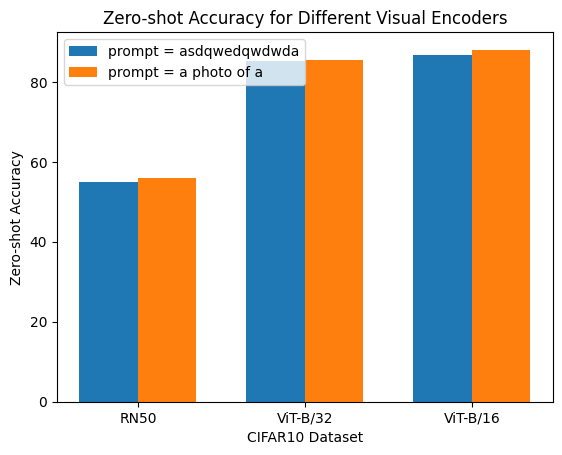

In [7]:
# 数据
models = ['RN50', 'ViT-B/32', 'ViT-B/16']
zero_shot_acc_1 = [54.95, 85.15, 86.83]
zero_shot_acc_2 = [55.84, 85.47, 88.03]

# 绘图
bar_width = 0.35
index = np.arange(len(models))

plt.bar(index, zero_shot_acc_1, bar_width, label='prompt = asdqwedqwdwda')
plt.bar(index + bar_width, zero_shot_acc_2, bar_width, label='prompt = a photo of a')

# 设置图表标题和标签
plt.xlabel('CIFAR10 Dataset')
plt.ylabel('Zero-shot Accuracy')
plt.title('Zero-shot Accuracy for Different Visual Encoders')
plt.xticks(index + bar_width / 2, models)
plt.legend()

# 显示图表
plt.show()

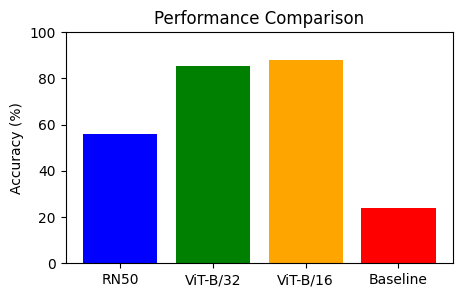

In [158]:
# 模拟数据
visual_backbones = ['RN50', 'ViT-B/32', 'ViT-B/16']
zero_shot_acc = [55.84,85.47,88.03]  # 使用实际的准确率数据
baseline_acc = 23.98  # 使用实际的准确率数据

# 绘制柱状图
plt.figure(figsize=(5, 3))
plt.bar(visual_backbones + ['Baseline'], zero_shot_acc + [baseline_acc], color=['blue', 'green', 'orange', 'red'])
plt.ylabel('Accuracy (%)')
plt.title('Performance Comparison')
plt.ylim(0, 100)  # 设置y轴范围为0到100，以适应准确率百分比
plt.show()

In [22]:
testing_loss = []
testing_acc = []

for VISUAL_BACKBONE in ['RN50', 'ViT-B/32', 'ViT-B/16']:
    
    model, preprocess = clip.load(name=VISUAL_BACKBONE, device=device, download_root='/shareddata/clip/')
    model.to(device)
    
    with torch.no_grad():
        model.eval()
 
    ##################### Write your answer here ##################
        correct_predictions=0
    
        for image, class_id in test_loader:
      
            image = image.to(device)
            class_id = class_id.to(device).long()
        
            logits = model_inference(model,image,text_inputs)
   
            predictions = logits.argmax(dim=-1)
            correct_predictions += (predictions == class_id).sum().item()

    
        val_acc = correct_predictions / len(test_set)

     ###############################################################
    print(f"the zero-shot performance on {dataset_name} is {val_acc*100:.2f}%, visual encoder is {VISUAL_BACKBONE}.")


the zero-shot performance on Cats vs. Dogs is 49.75%, visual encoder is RN50.
the zero-shot performance on Cats vs. Dogs is 49.05%, visual encoder is ViT-B/32.
the zero-shot performance on Cats vs. Dogs is 49.12%, visual encoder is ViT-B/16.


In [23]:
# 定义基准模型
class BaselineModel(nn.Module):
    def __init__(self, num_classes=2):
        super(BaselineModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3 * 224 * 224, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        return x

# 实例化模型和定义损失函数、优化器
baseline_model = BaselineModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(baseline_model.parameters(), lr=0.001, momentum=0.9)

# 训练模型
for epoch in range(5):  # 假设进行5个Epoch的训练
    baseline_model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = baseline_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# 在测试集上计算准确率
baseline_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = baseline_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Baseline Model Accuracy on Cats Dataset: {accuracy * 100:.2f}%')

Baseline Model Accuracy on Cats Dataset: 37.33%


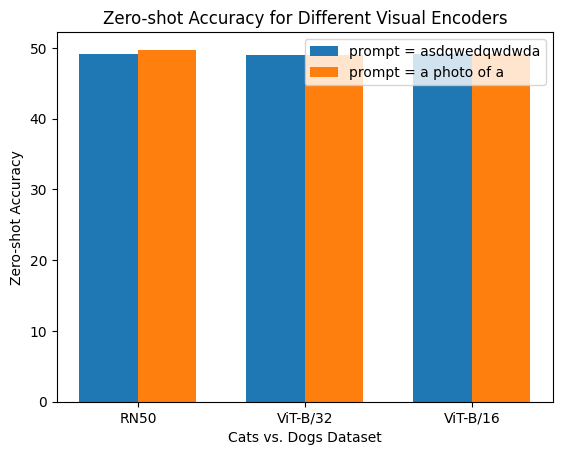

In [8]:
# 数据
models = ['RN50', 'ViT-B/32', 'ViT-B/16']
zero_shot_acc_1 = [49.19,48.98,49.12]
zero_shot_acc_2 = [49.75,49.05,49.12]

# 绘图
bar_width = 0.35
index = np.arange(len(models))

plt.bar(index, zero_shot_acc_1, bar_width, label='prompt = asdqwedqwdwda')
plt.bar(index + bar_width, zero_shot_acc_2, bar_width, label='prompt = a photo of a')

# 设置图表标题和标签
plt.xlabel('Cats vs. Dogs Dataset')
plt.ylabel('Zero-shot Accuracy')
plt.title('Zero-shot Accuracy for Different Visual Encoders')
plt.xticks(index + bar_width / 2, models)
plt.legend()

# 显示图表
plt.show()

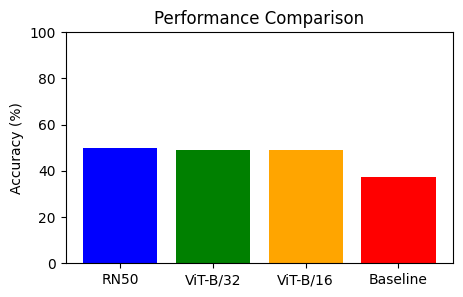

In [24]:
# 模拟数据
visual_backbones = ['RN50', 'ViT-B/32', 'ViT-B/16']
zero_shot_acc = [49.75,49.05,49.12]  # 使用实际的准确率数据
baseline_acc = 37.33  # 使用实际的准确率数据

# 绘制柱状图
plt.figure(figsize=(5, 3))
plt.bar(visual_backbones + ['Baseline'], zero_shot_acc + [baseline_acc], color=['blue', 'green', 'orange', 'red'])
plt.ylabel('Accuracy (%)')
plt.title('Performance Comparison')
plt.ylim(0, 100)  # 设置y轴范围为0到100，以适应准确率百分比
plt.show()

In [ ]:
testing_loss = []
testing_acc = []

for VISUAL_BACKBONE in ['RN50', 'ViT-B/32', 'ViT-B/16']:
    
    model, preprocess = clip.load(name=VISUAL_BACKBONE, device=device, download_root='/shareddata/clip/')
    model.to(device)
    
    with torch.no_grad():
        model.eval()
 
    ##################### Write your answer here ##################
        correct_predictions=0
    
        for image, class_id in test_loader:
      
            image = image.to(device)
            class_id = class_id.to(device).long()
        
            logits = model_inference(model,image,text_inputs)
   
            predictions = logits.argmax(dim=-1)
            correct_predictions += (predictions == class_id).sum().item()

    
        val_acc = correct_predictions / len(test_set)

     ###############################################################
    print(f"the zero-shot performance on {dataset_name} is {val_acc*100:.2f}%, visual encoder is {VISUAL_BACKBONE}.")


the zero-shot performance on FashionMNIST is 53.94%, visual encoder is RN50.


In [ ]:
import torch.optim as optim

class UpdatedBaselineModel(nn.Module):
    def __init__(self, num_classes=10):  # 更新为10个类别
        super(UpdatedBaselineModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3 * 224 * 224, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        return x

# 实例化模型和定义损失函数、优化器
updated_baseline_model = UpdatedBaselineModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(updated_baseline_model.parameters(), lr=0.001, momentum=0.9)

# 实例化模型和定义损失函数、优化器
updated_baseline_model = UpdatedBaselineModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(updated_baseline_model.parameters(), lr=0.001, momentum=0.9)

# 训练模型
for epoch in range(5):  # 假设进行5个Epoch的训练
    updated_baseline_model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = updated_baseline_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# 在测试集上计算准确率
updated_baseline_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = updated_baseline_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Updated Baseline Model Accuracy on Fashion Dataset: {accuracy * 100:.2f}%')

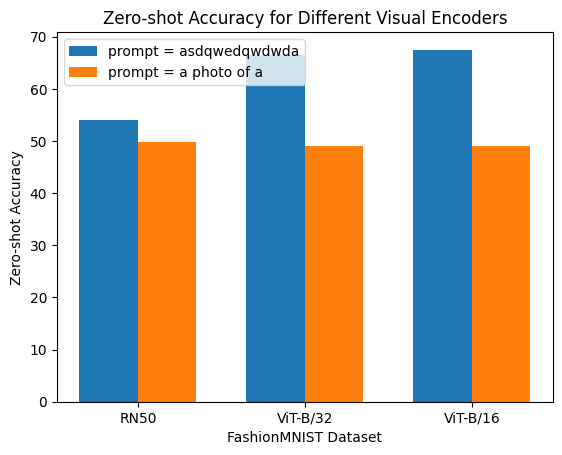

In [9]:
# 数据
models = ['RN50', 'ViT-B/32', 'ViT-B/16']
zero_shot_acc_1 = [53.94,66.45,67.50]
zero_shot_acc_2 = [49.75,49.05,49.12]

# 绘图
bar_width = 0.35
index = np.arange(len(models))

plt.bar(index, zero_shot_acc_1, bar_width, label='prompt = asdqwedqwdwda')
plt.bar(index + bar_width, zero_shot_acc_2, bar_width, label='prompt = a photo of a')

# 设置图表标题和标签
plt.xlabel('FashionMNIST Dataset')
plt.ylabel('Zero-shot Accuracy')
plt.title('Zero-shot Accuracy for Different Visual Encoders')
plt.xticks(index + bar_width / 2, models)
plt.legend()

# 显示图表
plt.show()

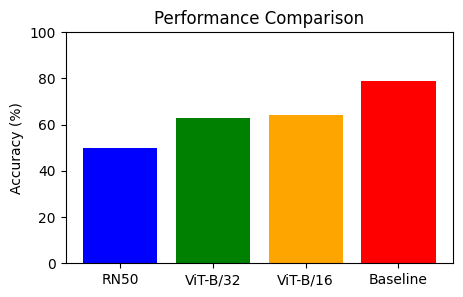

In [160]:
# 模拟数据
visual_backbones = ['RN50', 'ViT-B/32', 'ViT-B/16']
zero_shot_acc = [49.90,62.88,64.07]  # 使用实际的准确率数据
baseline_acc = 78.92  # 使用实际的准确率数据

# 绘制柱状图
plt.figure(figsize=(5, 3))
plt.bar(visual_backbones + ['Baseline'], zero_shot_acc + [baseline_acc], color=['blue', 'green', 'orange', 'red'])
plt.ylabel('Accuracy (%)')
plt.title('Performance Comparison')
plt.ylim(0, 100)  # 设置y轴范围为0到100，以适应准确率百分比
plt.show()